## Packages laden

In [1]:
import random
import warnings
import numpy as np
import pandas as pd
from graphviz import Source
from ipywidgets import interactive
from IPython.display import SVG,display
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score 
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import train_test_split as tts

warnings.filterwarnings('ignore')

## Customized Functions

In [2]:
# Funktion plot_tree gefunden auf
# https://towardsdatascience.com/interactive-visualization-of-
# decision-trees-with-jupyter-widgets-ca15dd312084

def plot_tree(crit, split, depth, min_split, min_leaf=0.2):
    '''
    Funktion plot_tree gefunden auf
    https://towardsdatascience.com/interactive-visualization-of-
    decision-trees-with-jupyter-widgets-ca15dd312084
    
    Teilweise verändert und an Titanic-Datensatz angepasst
    
    DecisionTreeClassifier wird auf Trainingsdatensatz angewandt 
    und entstandener Baum geplottet
    '''
    estimator = DTC(random_state = 0 
                    , criterion = crit
                    , splitter = split
                    , max_depth = depth
                    , min_samples_split=min_split
                    , min_samples_leaf=min_leaf)
    estimator.fit(xtrain, ytrain)
    graph = Source(export_graphviz(estimator
                                   , out_file=None
                                   , feature_names = 
                                     xtrain.columns.tolist()
                                   , filled = True))
   
    display(SVG(graph.pipe(format='svg')))
    return(estimator)

#------------------------------------------------------------------------

exclude =['PassengerId','Name','Ticket','Fare','Cabin']
def prepare_dataset(data,test_size=0.1,exclude_list=exclude):
    '''
    Datensatz Titanic wird zu Trainings- oder/und 
    Testsatz manipuliert.
    
    Dazu:
    - Entfernen von für den decision tree überflüssige Spalten 
      für bessere Entscheidungen, frei wählbar mit exclude_list
    - nans werden entfernt (Surrogate-Variablen werden hier 
      nicht besprochen)
    - strings werden umgelabelt, da dieser Classifier nur mit 
      numerischen Werten umgehen kann
    '''
    data   = data.drop(exclude_list,axis=1)
    data   = data.dropna()

    x1,x2,y1,y2 = tts(data,data.Survived,
                      test_size=test_size,random_state=0)

    x1,x2       = x1.drop('Survived',axis=1), x2.drop('Survived',axis=1)
    x1,x2,y1,y2 = x1.reset_index(drop=True),  x2.reset_index(drop=True),\
                  y1.reset_index(drop=True),  y2.reset_index(drop=True)
    
    # convert string to floats
    le          = LabelEncoder()
    for el in [x1,x2]:
        sex     = le.fit_transform(el.Sex)
        emb     = le.fit_transform(el.Embarked)   
        new     = pd.DataFrame({'Sex'     : sex,
                                'Embarked': emb}) 
        el.update(new) 
        del sex, emb, new
    return(x1, x2, y1, y2) 
  
#------------------------------------------------------------------------  
    
def create_tree_list(data,n_trees,n_subset,
                     test_size=0.1,exclude_list=exclude):
    '''
    Erstellt n_trees mal Decision Trees für den Datensatz Data. 
    Die Anzahl an Subsets wird durch n_subset festgelegt. 
    In dieser Funktion werden schon Trainings- und Testsatz erstellt, 
    sodass auch die Testsatzgröße 'test_size' als relativer Anteil und 
    die zu eliminierenden Spalten in 'exclude_list' als Liste vorgegeben
    werden müssen
    '''
    trees      = []
    out_of_bag = []
    xtrain, xtest, ytrain, ytest = prepare_dataset(data,test_size,
                                                   exclude_list)
    
    names = xtrain.columns.tolist()
    for i in range(n_trees): 
        index = random.sample(names,n_subset)
        xboot = xtrain.sample(xtrain.shape[0], replace=True, 
                              random_state=i)[index]
        yboot = ytrain.sample(xtrain.shape[0], replace=True, 
                              random_state=i)
        
        bootindices = xboot.index.values
        out_of_bag.append([xtrain.loc[~xtrain.index.isin(bootindices)],
                           ytrain.loc[~ytrain.index.isin(bootindices)]])
        
        tree  = DTC()
        tree.fit(xboot,yboot)
        trees.append([index,tree])
    return(trees, xtrain, xtest, ytrain, ytest,out_of_bag)

#------------------------------------------------------------------------

def out_of_bag_error(tree_list,oob_data):
    '''
    Berechnet den Out-Of-Bag-Error von eingespeisten Dataframes 
    (oob_data) über eine Liste von Decision Trees (tree_list), 
    welche als Random Forest fungieren. 
    Für len(oob_data) Dataframes werden sowohl Mittelwert als auch
    Median für den oob-Error = 1- accuracy berechnet und davon dann 
    auch nochmal jeweils Mittelwert und Median
    '''
    n       = len(tree_list)
    errors  = np.zeros((n,2))
    
    for i in range(n):
        x = oob_data[i][0]
        y = oob_data[i][1]
        
        error = np.zeros((len(y),1))
        
        indices, trees = [list(el) for el in zip(*tree_list)]
        values  = [tree.predict(x[index]) 
                   for index,tree in zip(indices,trees)]    
        summe   = np.array((sum(values)/100)).reshape(len(y),1)
        
        error[y == 0] = summe[y == 0]
        error[y == 1] = 1 - summe[y == 1]
        errors[i] = np.array((np.mean(error),np.median(error)))
    return(np.mean(errors[:,0]),np.median(errors[:,0]),
           np.mean(errors[:,1]),np.median(errors[:,1]))

#------------------------------------------------------------------------

def predict_samples(data,n_trees=100,n_subset=4,
                   test_size=0.1,exclude_list=exclude):
    '''
    Diese Funktion sagt als RandomForest-Algorithmus die Werte 
    0 (tot), 1 (überlebt), -1 (50/50,also keine Entscheidung) voraus. 
    Input ist der Originaldatensatz und die Variablen wie in obiger 
    Funktion beschrieben. Der Output sind 
    die Vorhersagen(Series),
    ytest(Series), also die echten Werte,
    die Genauigkeit acc(int) und
    n_ties, also die Werte = -1 und damit Anzahl an Gleichständen    
    '''
    tree_list,xtrain, xtest, ytrain, ytest = create_tree_list(data,
                                                             n_trees,
                                                             n_subset,
                                                             test_size,
                                                             exclude_list)[:5]
    n       = len(tree_list)
    indices, trees = [list(el) for el in zip(*tree_list)]
    values  = [tree.predict(xtest[index]) 
               for index,tree in zip(indices,trees)]    
    summe   = sum(values)
    predictions = pd.Series(0,index=np.arange(0,xtest.shape[0]))
    predictions[summe >  n/2] =  1
    predictions[summe == n/2] = -1
    n_ties = np.count_nonzero(predictions == -1)
    acc = accuracy_score(ytest,predictions)
    return(predictions,ytest,acc,n_ties) 

#------------------------------------------------------------------------

def improve_accuracy(data,n_trees=100,n_subset_list=[2,3,4],
                    test_size=0.1,exclude_list=exclude):
    '''
    Mit dieser Funktion kann der Tuning-Parameter n_subset 
    verändert werden, um eine höhere Genauigkeit zu erzielen. 
    Dazu müssen die Vorschläge für n_subset in der Liste 
    n_subset_list gespeichert werden. Empfohlen wird die Wurzel 
    aus der Anzahl an Attributen +-1 zu nehmen. Heraus kommt eine
    Liste an Einträgen, die wie in 'predict_samples' aufgebaut sind. 
    Die Genauigkeit ist also immer der dritte Wert. 
    '''
    return([predict_samples(data,n_trees,n_subset=el,
                            test_size=test_size,
                            exclude_list=exclude_list) 
           for el in n_subset_list])

Im Code wurde die Variable `random_state`$=0$ gesetzt, damit die normalerweise zufälligen Werte nicht mehr zufällig zur besseren Nachvollziehbarkeit sind.

# Decision Trees

In diesem Kapitel beginne ich, mich mithilfe des Titanic-Datensatzes an *Decision Trees* heranzutasten.  
Diese gehören, wie viele andere Klassifikationsmodelle auch, zu den *supervised* lernenden Algorithmen, das heißt, er wird bereits mit den Klassen im Datensatz trainiert. Sie können sogar für Regressionen benutzt werden. Weiterhin ist dieser Classifier ein CART-(classification and regression tree) und *greedy*, also gieriger, Algorithmus. Das bedeutet, dass ein unperfekter Baum entstehen kann, was bedeutet:  
Es gibt bessere Vorhersagen als diese.  
Denn auch wenn Decision Trees 
* sehr einfach zu verstehen
* intuitiv lesbar
* skalen-, verteilungs- und ausreißerinvariant   

sind, ist der einzige Punkt, der sie nicht zum ultimativen Tool macht, ihre schlechte Genauigkeit (*Hastie T., Tibshirani R., Friedman J.: 'The Elements of Statistical Learning',2009*).
Das hat auch damit zu tun, dass sie gegenüber noisy Daten empfindlich reagieren und damit ein Overfitting zustande kommen kann.

## Daten laden

In [3]:
train  = pd.read_csv("train.csv",sep=',')

Nun, da die Daten geladen wurden, ist es wichtig, die Spalten, die für die Entscheidungen des Decision Trees nicht nützlich sind, zu eliminieren. Dazu schauen wir uns erstmal alle Attribute an:

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


* PassengerId: Passagiernummer
* Survived   : ob der Passagier überlebt hat (nur im Trainingsdatensatz vorhanden)
* Pclass     : Passagierklasse 1,2,3
* Name       : Name des Passagiers
* Sex        : Geschlecht des Passagiers 
* Age        : Alter des Passagiers
* SibSp      : Anzahl an Geschwistern und Ehegatten
* Parch      : Anzahl der Elternteile und Kinder
* Ticket     : Ticketnummer
* Fare       : Fährkosten
* Cabin      : Kabinennummer
* Embarked   : Ort des Zustiegs (S,C,Q)

Im nächsten Schritt übernimmt die Funktion `prepare_dataset` das Eliminieren der Spalten PassengerId, Survived, Name, Ticket, Fare und Cabin, entfernt Samples mit `nan`, bereitet den x und y Trainingsdatensatz vor und labelt Strings zu numerischen Werten um, da dieser Classifier nicht mit Strings umgehen kann. Der Testsatz wird auch entsprechend manipuliert.

In [5]:
xtrain, xtest, ytrain, ytest = prepare_dataset(train)

Durch das Entfernen der `nan`-Zeilen wurde der Trainingsssatz erheblich ausgedünnt:

In [6]:
print('Trainingssatz Originalgröße: ' 
      + str(train.shape)
      + '   Ausgedünnt: '
      + str(xtrain.shape)
      + '   Zeilenverlust: '
      + str(train.shape[0]-xtrain.shape[0]))

Trainingssatz Originalgröße: (891, 12)   Ausgedünnt: (640, 6)   Zeilenverlust: 251


So sieht der Trainingssatz nun aus:

In [7]:
xtrain.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked
0,2,0,18.0,0,2,2
1,2,0,30.0,3,0,2
2,3,1,42.0,0,1,2
3,1,1,40.0,0,0,2
4,2,1,2.0,1,1,2


Der Testsatz hat folgende Größe:

In [8]:
print(xtest.shape)

(72, 6)


Nun wollen wir den Algorithmus trainieren und anschließend einen Baum plotten.   
Aus Platzgründen wurde hier eine Baumtiefe von $2$ gewählt. 

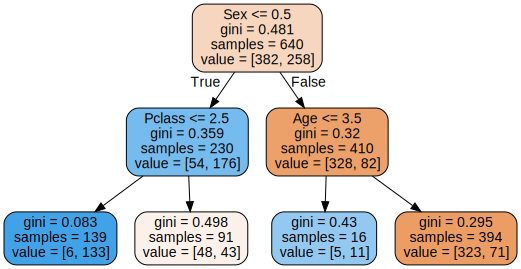

In [9]:
dc = DTC(max_depth=2,random_state=0)
dc.fit(xtrain,ytrain)

names = xtrain.columns.tolist()

dot_data = export_graphviz(dc,
                           feature_names = names,
                           out_file = None,
                           filled   = True,
                           rounded  = True)
graph = Source(dot_data,filename='tree.png',format='png')
graph

Wie ist dieser Baum zu interpretieren?  
Für diesen Algorithmus ist es umso einfacher, wenn auf einer Seite mehr Personen sind als auf der anderen. Annähernd gleiche Verteilungen sind für ihn schwierig. Genau das drückt der Gini-Index aus. Je höher er liegt, desto unreiner ist der Knoten. Durch ihn wird auch entschieden, welches Attribut nach oben kommt. Oben in der Wurzel werden die $640$ Passagiere nach den Geschlechtern getrennt, $<= 0.5$ heißt $=0$ und nach unserem Label weiblich. Ist das also wahr, gehen wir nach links, ist die Person männlich, gehen wir nach rechts. In der Wurzel wird auch bereits angegeben, dass es $382$ Frauen und $258$ Männer gibt. Gehen wir nun nach links, ist die nächste Abfrage die der Passagierklasse. Gehört die Frau zur ersten oder zweiten Klasse, gehen wir nach links, für die dritte nach rechts. Nun ist es hier so, dass von $139$ Frauen aus der ersten und zweiten Klasse $6$ überleben und $133$ umkommen. Man beachte, dass der Gini-Index hier fast rein ist, da die Anteile auch extrem verteilt sind. In der dritten Klasse ist er wiederum sehr hoch, da die Passagierzahl recht gleichmäßig aufgeteilt ist. 

Im Testsatz dürfen auch  `nan` vorkommen, denn Decision Trees kommen nach dem Lernen auch mit fehlenden Informationen aus. Jede Lücke kann durch sogenannte Surrogate-Variablen aufgefangen werden. Dies wird hier jedoch erstmal nicht behandelt.  

Die Besonderheit im folgenden Code ist, dass durch das Package `ìpywidgets` der Decision Tree interaktiv verändert werden kann:

In [10]:
inter=interactive(plot_tree, 
                  crit = ["gini", "entropy"],
                  split = ["best", "random"],
                  depth=[1,2,3,4,5,6,7],
                  min_split=(0.1,1),
                  min_leaf=(0.1,0.5))

display(inter)

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

Schauen wir uns nun die Vorhersagen und deren Genauigkeit an:

In [11]:
labels = dc.predict(xtest)
acc    = accuracy_score(ytest,labels)
print('Genauigkeit: ' 
      + str('{:3.1f}'.format(acc*100))
      + ' %\nDas heißt: '
      + str(int(len(labels)-acc*len(labels)))
      + ' von '
      + str(len(labels))
      + ' Samples wurden falsch klassifiziert')

Genauigkeit: 77.8 %
Das heißt: 16 von 72 Samples wurden falsch klassifiziert


Das halte ich für eine zu niedrige Genauigkeit. Auch ist die Varianz, also die Instabilität beim Repitieren der Genauigkeit, sehr hoch. Ein möglicher Grund kann der recht überschaubare Datensatz oder das falsche *Pruning*, also Schneiden des Baumes, sein. Natürlich kann man das Kriterium noch ändern und statt des Gini-Indizes die Entropie, das Chi-Quadrat oder die Varianz-Reduktion wählen, wobei für diesen Classifier die letzten beiden nicht explizit verfügbar sind. Vielleicht kam hier auch ein Overfitting zustande. Dies kann durch sogenannte *Random Forests* eliminiert werden.

# Random Forests

Ein *Random Forest* besteht nicht aus einem einzigen Decision Tree, sondern, wie der Name sagt, aus einem ganzen Wald zufällig gewählter, nicht-beschnittener Bäume. Bei der Klassifikationsmethode wird dann durch Mehrheitsbeschluss ein endgültiges Ergebnis ermittelt. So kann ein Overfitting vermieden und die Gefahr durch ausreißende Bäume bzw. Fehlentscheidungen minimiert werden. Durch dieses Vorgehen ist die Vorhersage-Genauigkeit wesentlich höher als durch einen einzigen Decision Tree.  

In diesem Kapitel werde ich wie folgt vorgehen:
Ich werde den RandomForest-Algorithmus stückweise aufbauen, bis der DecisionTreeClassifier angewandt werden kann. Natürlich gibt es bereits den RandomForestClassifier in Python. Diesen werde ich nochmal zum Vergleich der Genauigkeit mit dem manuellen Algorithmus und dem Decision Tree aus dem vorherigen Kapitel am Ende anwenden.  

## manueller Algorithmus
In folgendem Bild sehen wir eine endliche, vom Benutzer festgelegte Anzahl $n$ an Bäumen. Diese können einen unterschiedlichen Aufbau, eine andere Wurzel oder unterschiedliche Baumtiefen haben. Wie kommt dies zustande?

![Aufbau eines Random Forests](randomforesttrees.png)

### Bootstrap
Der Originaldatensatz, in diesem Fall der Trainingssatz, mit (Zeilen-)Länge $l$ wird dem Bootstrap-Verfahren unterzogen. Dazu werden $n$ Datensätze wie folgt konstruiert:  
Es wird $l$ mal zufällig ein Sample aus dem Trainingssatz gezogen, sodass Original und gebootstraptes Set dieselbe Größe haben. Dabei wird dieses Sample sozusagen wieder zurückgelegt, sodass Wiederholungen innerhalb jedes Satzes erlaubt und sogar erwünscht sind.  
In diesem Beispiel gilt bzw. wurde festgelegt:  
* Anzahl der Bäume:$n =100$
* Länge jedes Datensatzes: $l=640$  

Folgender Code stammt aus obiger Funktion `create_tree_list` und wird zum Nachvollziehen nochmal stückweise angewendet. Zunächst wird eine leere Liste für die $100$ Bäume erstellt. In `names` speichern wir alle möglichen Spaltennamen des Trainingsdatensatzes: 


In [12]:
trees = []
names = xtrain.columns.tolist()
print(names)

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']


Ein Unterschied zwischen RandomForest- und DecisionTree-Algorithmus ist, dass beim RandomForest nicht alle Attribute betrachtet werden, sondern nur ein sogenanntes *subset*. Hier werden nun statt allen, also $6$, nur $4$ Attribute in den Algorithmus eingespeist. Um die optimale Wahl dieses Tuning-Parameteres kümmern wir uns später. Die Attribut-Auswahl geschieht zufällig und wird der Variable `index` zugeschrieben. In `xboot` wird der Bootstrap-Datensatz gespeichert und seine Labels in `yboot`. Anschließend werden diese in den DecisonTreeClassifier eingespeist und die Attribut-Labels und die Bäume in der Liste `trees` gespeichert. 

In [13]:
for i in range(100): 
    index = random.sample(names,3)
    xboot = xtrain.sample(xtrain.shape[0], replace=True, 
                          random_state=i)[index]
    yboot = ytrain.sample(xtrain.shape[0], replace=True, 
                          random_state=i)
    tree  = DTC()
    tree.fit(xboot,yboot)
    trees.append([index,tree])
print(trees[0][0])
print(trees[0][1])

['Parch', 'Sex', 'Embarked']
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


### Out-Of-Bag-Error
Bereits hier kann der *Out-Of-Bag-Error* festgestellt werden. Zunächst werden aus den Bootstrap-Sets alle Beobachtungen, die nicht in die Decision Trees eingeflossen sind, gesammelt. Das ist der sogenannte Out-Of-Bag-Datensatz. Dieser wird dann auf die bereits erstellten Bäume angewendet und vorhergesagt. Da aber die Labels für diese Beobachtungen bereits feststehen, kann durch diesen Vorgang überprüft werden, wie gut sich die Bäume verhalten.  
Die Formel für diesen Fehler lautet: $\delta=1-acc$.  
Man berechnet für jedes Sample in jedem der $100$ Datensätze diesen Fehler und nimmt gängigerweise dann den Mittelwert. Ich habe noch den Median dazugenommen. So kommen dann $100$ Mittelwerte und $100$ Mediane zustande. Am Ende werden nochmal daraus Mittelwerte und Mediane berechnet, sodass wir $4$ Werte haben.  
Anzumerken ist hier noch, dass die Funktion `out_of_bag_error` mit rund $42$ s sehr langsam ist. Das liegt auch daran, dass der Algorithmus mindestens $n\_trees * length(each\_dataset)$ Operationen ausführen muss. In diesem Fall $100*240$, also ~$24.000$ mal.  

In [14]:
created  = create_tree_list(train,100,4)
treelist = created[0]
oobdata  = created[-1]
mean_med = out_of_bag_error(treelist,oobdata)

In [15]:
print('Mittelwert des Mittelwerts: ' 
      + str('{:6.4f}'.format(mean_med[0]))
      + '\t\tMittelwert des Medians: ' 
      + str('{:6.4f}'.format(mean_med[2]))
      + '\nMedian des Mittelwerts:     ' 
      + str('{:6.4f}'.format(mean_med[1]))
      + '\t\tMedian des Median: ' 
      + '\t' + str('{:6.4f}'.format(mean_med[3])))

Mittelwert des Mittelwerts: 0.1840		Mittelwert des Medians: 0.1118
Median des Mittelwerts:     0.1841		Median des Median: 	0.1100


Allgemein liegt der Median immer etwas unter dem Mittelwert, was bedeutet, dass Ausreißer den Mittelwert nach oben ziehen. Nochmals den Mittelwert und Median des Mittelwerts und Medians zu berechnen, war in diesem Fall nicht nötig, da sie sich kaum voneinander unterscheiden. Prinzipiell sollten wir uns vor Augen führen, dass die Decision Trees, welche den Random Forest bilden, mindestens eine Fehlerrate von $10 \%$ haben, das bedeutet, hier treffen von $100$ Bäumen mindestens $10$ die falsche Entscheidung.

### Vorhersage und Klassifikation
Im nächsten Schritt werden die Labels und Bäume separiert. Dann wird der Testsatz `xtest` durch jeden Baum vorhergesagt, sodass $100$ Listen mit jeweils $72$ Einträgen herauskommen. 

In [16]:
indices, trees1 = [list(el) for el in zip(*trees)]
values  = [tree.predict(xtest[index]) 
           for index,tree in zip(indices,trees1)]
print("Länge der Liste 'Values': " 
      + str(len(values))
      + '\nLänge eines Eintrags:     '
      + str(len(values[0])))

Länge der Liste 'Values': 100
Länge eines Eintrags:     72


Nun werden alle Listen elementweise addiert, sodass sich ein Bereich von $0 \leq x \leq 100$ für die $72$ Werte ergibt. Ist ein Wert nun $>50$, wird die Variable `predictions` genau an dieser Stelle $=1$ (überlebt) gesetzt. Haben wir eine Summe $=50$, also $100/2$, so setze ich ihn auf $-1$ und treffe damit also gar keine Entscheidung. Hier wäre eine andere Möglichkeit, einfach einen weiteren Baum entscheiden zu lassen, aber dann könnte ich auch einfach zufällig $0$ oder $1$ wählen. Das halte ich für keine gute Aussage. Alle Werte $\leq 50$ sind bereits $0$ (stirbt). 

In [17]:
summe   = sum(values)

predictions = pd.Series(0,index=np.arange(0,xtest.shape[0]))
predictions[summe >  100/2] =  1
predictions[summe == 100/2] = -1

Wir können uns nun die Genauigkeit und Anzahl an 'Non Decisions' anschauen:

In [18]:
print(str(np.count_nonzero(predictions == -1))
      + 'x wurde nicht entschieden'
      + '\nGenauigkeit: '
      + str('{:3.1f}'.format(accuracy_score(ytest,predictions)*100)) 
      + ' %')
            

0x wurde nicht entschieden
Genauigkeit: 77.8 %


Leider ist bei diesem Algorithmus die Varianz sehr hoch, d.h. bei mehrfacher Anwendung auf denselben Testsatz liegen die Genauigkeitswerte sehr weit auseinander. Nun ist hier die Genauigkeit dieselbe wie bei dem einzelnen Decision Tree und immer noch nicht zufriedenstellend. 

Um die Genauigkeit noch zu steigern, kann der Tuning-Parameter `n_subset` variiert werden. Mithilfe der Funktion `improve_accuracy` geht das ganz einfach:

In [19]:
liste    = [2,3,4,5,6]
ergebnis = improve_accuracy(train,n_subset_list=liste)

In [20]:
[print('Für m=' 
       + str(k) 
       + ': ' 
       + str('{:3.1f}'.format(el[2]*100)) 
       + ' %') 
 for k,el in zip(liste,ergebnis)]

Für m=2: 77.8 %
Für m=3: 79.2 %
Für m=4: 79.2 %
Für m=5: 81.9 %
Für m=6: 81.9 %


[None, None, None, None, None]

Das Maximum haben wir bei $5$ oder $6$ Variablen. Damit hätten wir eine Genauigkeit von fast $82 \%$ (was ich für einen guten Classifier für immer noch zu wenig halte). Jedoch macht es wenig Sinn, die volle Zahl an Attributen zu wählen. Die nächstgelegenere Wahl wäre also $m=4$. Somit muss der Parameter nicht mehr geändert werden. Schön zu erkennen ist hier die eben erwähnte Varianz. War der Wert zuvor $77.8 \%$, liegt er nun bei $79.2 \%$.

## eingebetteter Algorithmus
Zum Schluss werde ich nochmal den in Python zur Verfügung stehenden Classifier *RandomForestClassifier* mit denselben Eigenschaften und Optionen anwenden, um die Genauigkeit meines Algorithmus zu validieren. 

In [21]:
rc = RFC(max_features=4,random_state=0)
rc.fit(xtrain,ytrain)

ylabel = rc.predict(xtest)
print('Genauigkeit: ' 
      + str('{:3.1f}'.format(accuracy_score(ytest,ylabel)*100)) 
      + ' %')

Genauigkeit: 77.8 %


Hier erzielen wir wieder die gleiche Genauigkeit. Nun will ich es wissen und probiere noch andere $m$ aus:

In [22]:
for i in [2,3,4,5,6]:
    rc = RFC(max_features=i,random_state=0)
    rc.fit(xtrain,ytrain)

    ylabel = rc.predict(xtest)
    print('Genauigkeit für m=' 
          + str(i)   
          + ': ' 
          + str('{:3.1f}'.format(accuracy_score(ytest,ylabel)*100)) 
          + ' %') 

Genauigkeit für m=2: 76.4 %
Genauigkeit für m=3: 79.2 %
Genauigkeit für m=4: 77.8 %
Genauigkeit für m=5: 80.6 %
Genauigkeit für m=6: 77.8 %


$m=5$ scheint hier der optimale Parameter zu sein. Jedoch sehen wir beim Vergleich mit den vorherigen Werten die wiederauftretende Varianz. Deshalb ist hier jede Entscheidung mit Vorsicht zu genießen.

## Fazit
Nun habe ich einen guten Überblick über Decision Trees und Random Forests erhalten. Ein Decision Tree alleine ist nicht immer so effektiv, daher ist der RandomForest zur Klassifizierung besser geeignet.  
Weiterhin werde ich mir für den RandomForest-Algorithmus anschauen, wie die Entscheidungswege verlaufen und Inspirationen durch andere Arbeiten einholen.

Ich bedanke mich für das Interesse und Lesen dieser Arbeit.